##1. 데이터 셋 다운로드

In [ ]:
!unzip -qq /content/custom_dataset.zip

In [ ]:
# 경로확인
!pwd

/content


In [ ]:
# data.yaml 파일 출력

!cat /content/custom_dataset/data.yaml

cat: /content/custom_dataset/data.yaml: No such file or directory


In [ ]:
# 데이터 개수 확인
import yaml


# data.yaml 파일을 읽어 환경 설정 내용 불러오기
with open('/content/custom_dataset/data.yaml') as f:
    conf = yaml.load(f,Loader=yaml.SafeLoader)

number_of_classes = conf['nc']
class_names = conf['names']

print('클래스 개수:', number_of_classes)
print('클래스 이름:', class_names)

클래스 개수: 3
클래스 이름: ['fall', 'head', 'stand']


In [ ]:
import os

train_path = '/content/custom_dataset/train/'
valid_path = '/content/custom_dataset/valid/'
test_path = '/content/custom_dataset/test/'

train_file_list = os.listdir(train_path + 'images/')
valid_file_list = os.listdir(valid_path + 'images/')
test_file_list = os.listdir(test_path + 'images/')

print(f'학습 데이터 개수: {len(train_file_list)}개')
print(f'평가 데이터 개수: {len(valid_file_list)}개')
print(f'테스트 데이터 개수: {len(test_file_list)}개')

학습 데이터 개수: 3336개
평가 데이터 개수: 317개
테스트 데이터 개수: 159개


### 이미지를 화면에 출력하기 

In [ ]:
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80 # Dot Per Inch

이미지 해상도: (416, 416, 3)


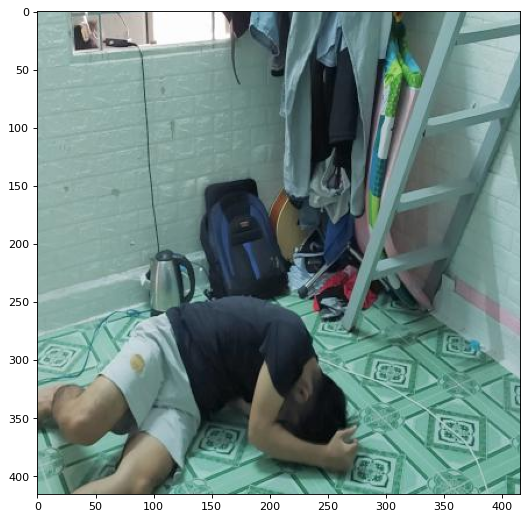

In [ ]:
import PIL.Image as Image
import cv2


image_name = 'fall_img_1001_jpg.rf.2050c4f382320ffa51f68479fd45d046.jpg'

img = cv2.imread(train_path + 'images/' + image_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 기본적으로 OpenCV는 BGR 형식을 따르므로, RGB 형식으로 변환
print(f'이미지 해상도: {img.shape}')

plt.imshow(img)
plt.show()

### 이미지를 바운딩 박스와 함께 출력하기 

클래스: 0, 중심 좌표: (0.32933, 0.79567), 너비: 0.65745, 높이: 0.40625
클래스: 1, 중심 좌표: (0.58173, 0.81971), 너비: 0.12380, 높이: 0.14183


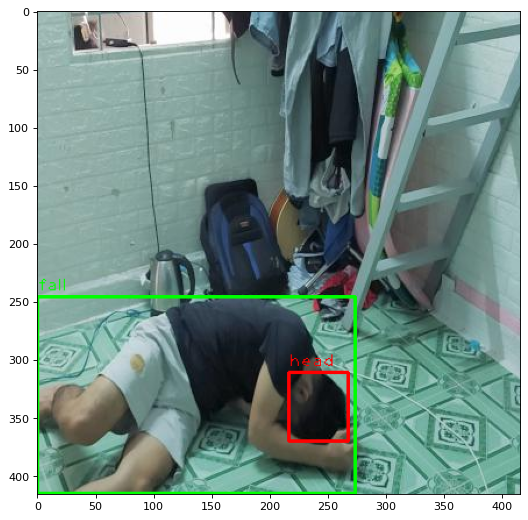

In [ ]:
img = cv2.imread(train_path + 'images/' + image_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV는 기본적으로 BGR 형식을 따르므로, RGB 형식으로 변경

label_name = 'fall_img_1001_jpg.rf.2050c4f382320ffa51f68479fd45d046.txt'

# 특정한 레이블 파일을 읽어 확인
with open(train_path + 'labels/' + label_name) as f:
    # 각 객체(object)의 바운딩 박스 정보를 하나씩 확인하며
    for instance in f.readlines():
        image_width, image_height = 416, 416

        label, x, y, width, height = map(float, instance.strip().split())
        print(f'클래스: {int(label)}, 중심 좌표: ({x:.5f}, {y:.5f}), 너비: {width:.5f}, 높이: {height:.5f}')

        if int(label) == 0:
            c = (0, 255, 0) # mask인 경우 초록색
        elif int(label) == 1:
            c = (255, 0, 0) # no-mask인 경우 빨간색
        
        # 왼쪽 위 좌표와 오른쪽 아래 좌표
        x1, y1 = image_width * (x - width / 2), image_height * (y - height / 2)
        x2, y2 = image_width * (x + width / 2), image_height * (y + height / 2)

        # 사각형 그리기
        cv2.rectangle(
            img,
            (int(x1), int(y1)), # 왼쪽 위 좌표
            (int(x2), int(y2)), # 오른쪽 아래 좌표
            color=c, # 색상
            thickness=2, # 굵기
        )

        # 텍스트 그리기
        cv2.putText(
            img,
            class_names[int(label)], # 텍스트 내용
            (int(x1), int(y1) - 5), # 위치
            fontFace=cv2.FONT_HERSHEY_PLAIN, # 글씨체
            fontScale=1.0, # 글씨 크기
            color=c, # 색상
            thickness=1, # 굵기
        )

plt.imshow(img)
plt.show()

## YOLOv5 모델에 적용하기 

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12310, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 12310 (delta 16), reused 21 (delta 15), pack-reused 12287
Receiving objects: 100% (12310/12310), 12.63 MiB | 21.34 MiB/s, done.
Resolving deltas: 100% (8479/8479), done.


In [ ]:
%cd yolov5

/content/yolov5


In [ ]:
!pip install -qr requirements.txt 

     |████████████████████████████████| 1.6 MB 7.4 MB/s 


In [ ]:
!python train.py --img 416 --epochs 50 --batch 32 --data /content/custom_dataset/data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name custom_fall_yolov5

train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=/content/custom_dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=custom_fall_yolov5, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-110-ga4ed988 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_

In [ ]:
import joblib

In [ ]:
import torch

In [ ]:
from torch import hub

In [ ]:
path='/content/yolov5/runs/train/custom_fall_yolov5/weights/best.pt'

In [ ]:
joblib.dump(path,'./knn_model.pkl')

['./knn_model.pkl']

### 학습결과 확인하기 

In [ ]:
!ls /content/yolov5/runs/train/custom_fall_yolov5

events.out.tfevents.1662801333.713e0dbf0ca0.317.0  train_batch0.jpg
hyp.yaml					   train_batch1.jpg
labels_correlogram.jpg				   train_batch2.jpg
labels.jpg					   weights
opt.yaml


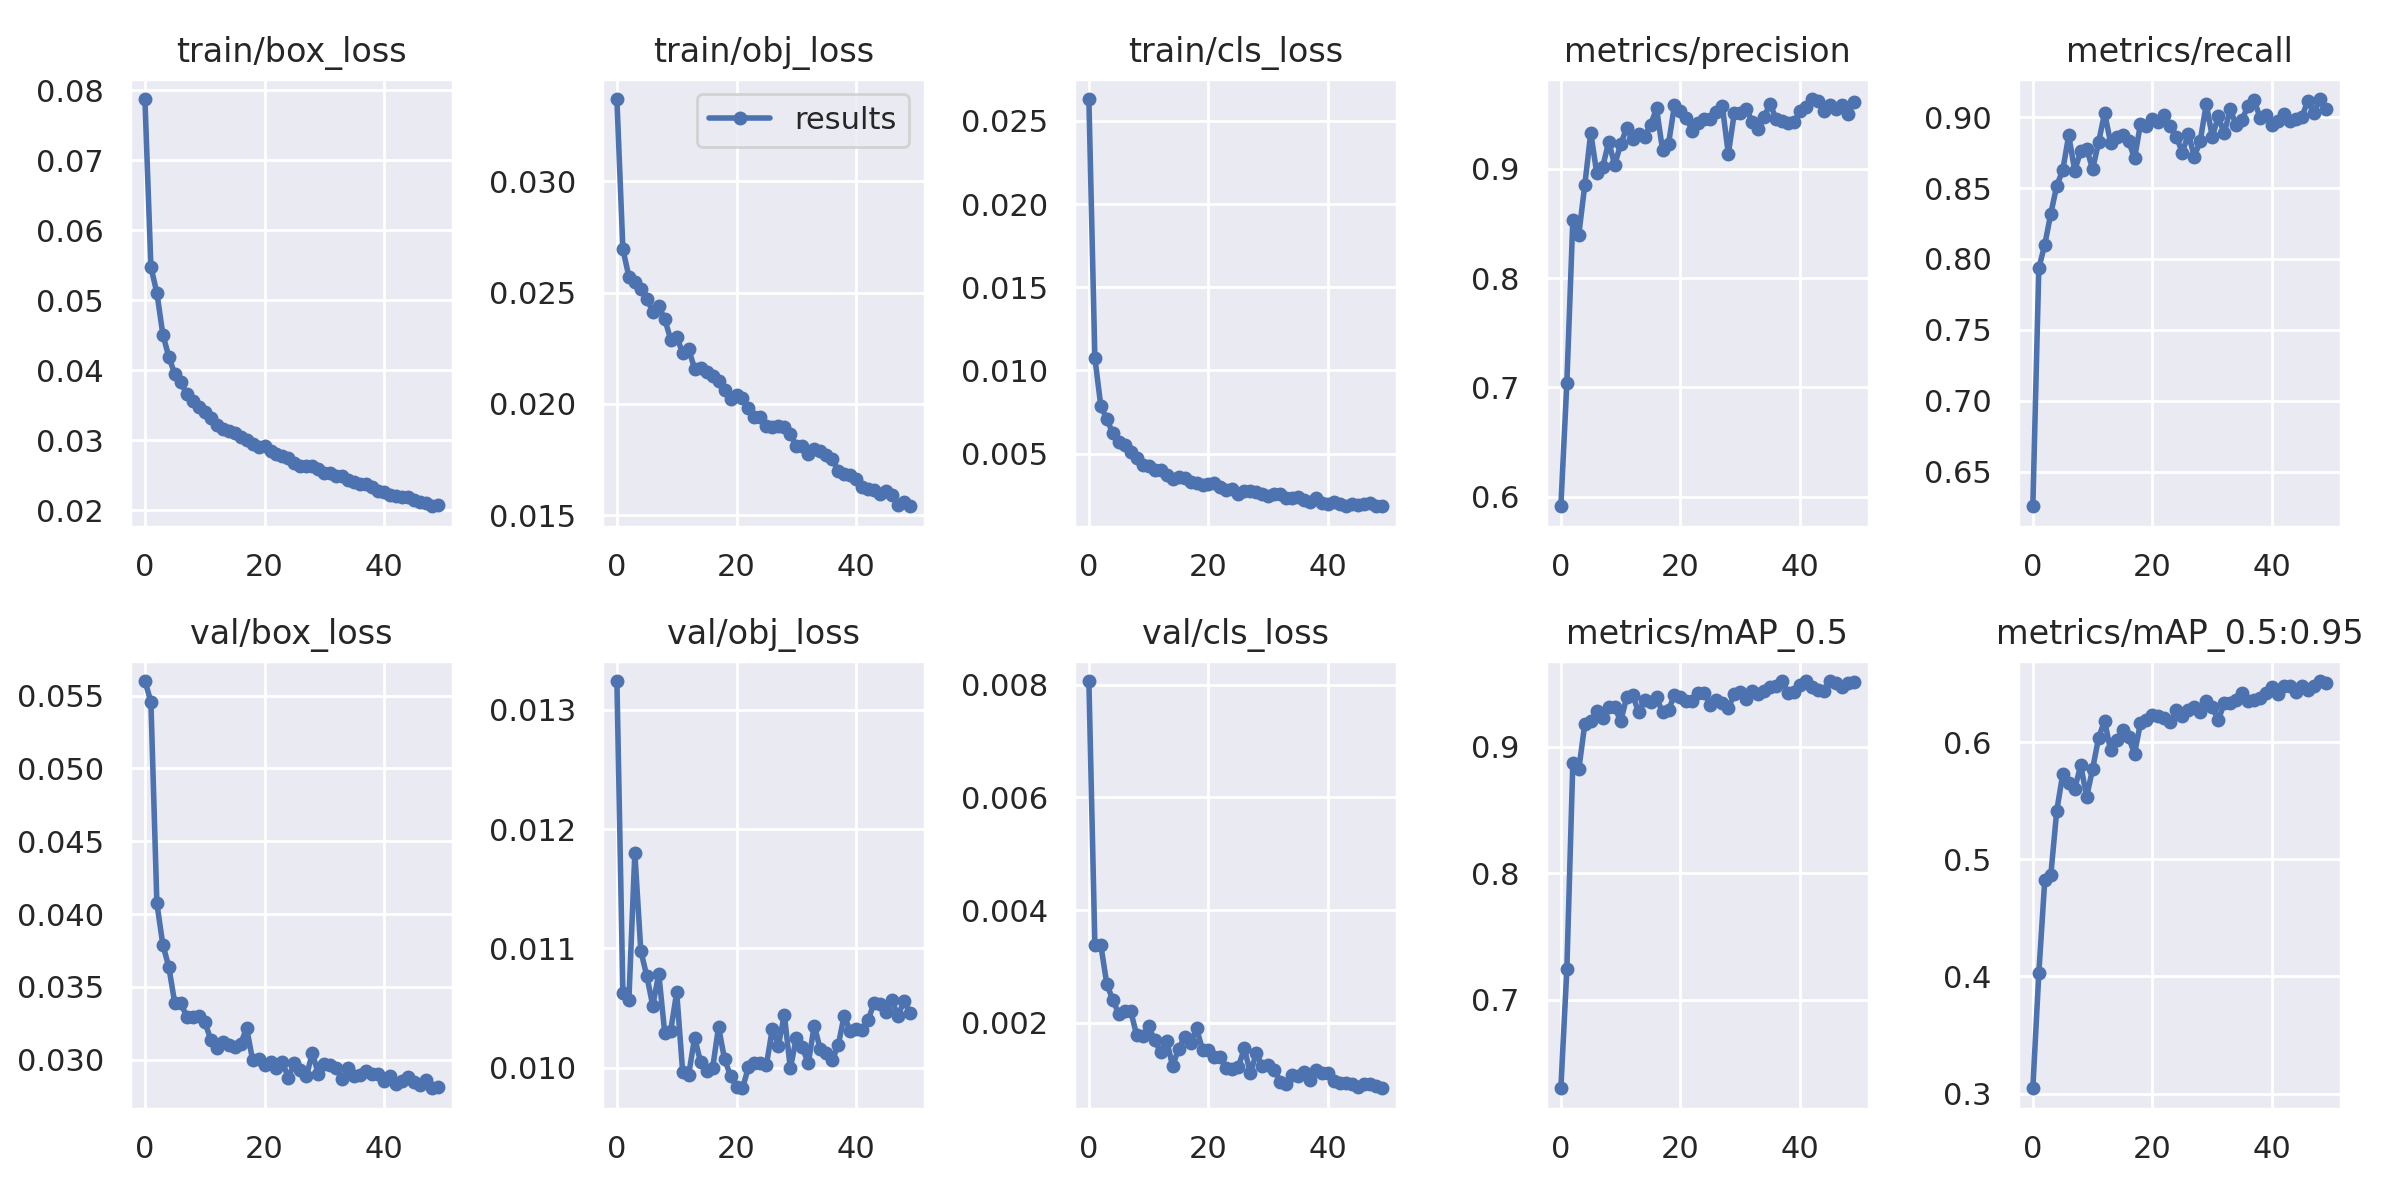

In [ ]:
Display(filename='/content/yolov5/runs/train/custom_fall_yolov52/results.png', width=1080)


```
train_batch0.jpg: 첫 번째 학습 배치에 포함된 정답 이미지
test_batch0_pred.jpg: 첫 번째 테스트 배치에 포함된 이미지에 대한 예측 결과
```

In [ ]:
from IPython.display import Image as Display # to display images

Display(filename='/content/yolov5/runs/train/custom_fall_yolov52/train_batch0.jpg', width=800)

In [ ]:
Display(filename='/content/yolov5/runs/train/custom_fall_yolov52/val_batch0_pred.jpg', width=800)

## 텐서보드(TensorBoard)를 이용해 학습결과 확인하기

In [ ]:
%reload_ext tensorboard
# TensorBoard 준비하기
%load_ext tensorboard
%tensorboard --logdir ./runs

### 테스트 하기 

### 학습된 가중치 파일 다운로드

- google colab으로 부터 모델 가중치 파일(.pt)를 다운로드(download)한다
- 추후에 저장된 가중치 파일을 다시 불러온뒤 추론을 진행할수 있다

In [ ]:
from google.colab import files

files.download('/content/yolov5/runs/train/custom_fall_yolov5/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 원하는 동영상에 대하여 추론(Inference)하기

1.weights: 추론을 위해 사용할 학습된 모델 가중치 파일 경로
2.source: 이미지 파일 경로(이미지, 비디오, 폴더, 이미지 전부 사용 가능)
3.img: 이미지 해상도 (데이터셋의 해상도)
4.conf: 객체(object) confidence threshold (낮을수록 많은 객체를 탐지)
5.iou: NMS (Non-Maximum Suppression)을 위한 IOU threshold

- 실제 입력 이미지의 크기가 416 X 416이 아니어도, 네트워크에 포워딩(forwarding)할 때는 416 X 416으로 변경하여 처리합니다.
- 따라서 다양한 해상도(resolution)를 가지는 이미지를 입력으로 넣을 수 있습니다.

In [ ]:
!python detect.py \
--weight /content/yolov5/runs/train/custom_fall_yolov52/weights/best.pt \
--source /content/custom_dataset/falldown.mp4 \
--img 416 \
--conf 0.25

In [ ]:
!python detect.py \
--weight /content/yolov5/runs/train/custom_fall_yolov5/weights/best.pt \
--source 0 \
--img 416 \
--conf 0.25

detect: weights=['/content/yolov5/runs/train/custom_fall_yolov5/weights/best.pt'], source=0, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-110-ga4ed988 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
cv2.imshow() is disabled in Docker environments
Traceback (most recent call last):
  File "detect.py", line 255, in <module>
    main(opt)
  File "detect.py", line 250, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func

In [ ]:
from google.colab import files
files.download('/content/yolov5/runs/detect/exp2/falldown.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#https://www.kaggle.com/code/espsiyam/yolov5-ensemble-tta-transfer-learning-hpt/notebook
#https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9807301

In [2]:
import joblib

In [5]:
with open('/content/best.pt', 'wb') as f:
     joblib.dump('/content/best.pt',('./yolo_model.pkl'))

In [8]:
with open('/content/best.pt') as m :
   joblib.dump(m,'/yolo1_model.pkl')

TypeError: ignored

In [9]:
import pickle

In [12]:
with open('/content/best.pt', 'wb') as f:
    pickle.dump('/content/best.pt', f)